In [22]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from pandas import Series
import statsmodels.api as sm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance,plot_tree,to_graphviz


In [28]:
data = pd.read_csv('D:/statistics/machine learning in action/GiveMeSomeCredit/data.csv')
print(data.info())
y=data.ix[:,0]
x=data.ix[:,1:]
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0) 
print('训练集大小：',X_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',X_test.shape,y_test.shape)  # 测试集样本大小


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145344 entries, 0 to 145343
Data columns (total 11 columns):
SeriousDlqin2yrs                        145344 non-null int64
age                                     145344 non-null int64
NumberOfDependents                      145344 non-null float64
MonthlyIncome                           145344 non-null float64
DebtRatio                               145344 non-null float64
RevolvingUtilizationOfUnsecuredLines    145344 non-null float64
NumberOfOpenCreditLinesAndLoans         145344 non-null int64
NumberRealEstateLoansOrLines            145344 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    145344 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    145344 non-null int64
NumberOfTimes90DaysLate                 145344 non-null int64
dtypes: float64(4), int64(7)
memory usage: 12.2 MB
None
训练集大小： (101740, 10) (101740,)
测试集大小： (43604, 10) (43604,)


In [24]:
# 决策树分箱
def optimal_binning_boundary(x: pd.Series, y: pd.Series, nan: float = -999.) -> list:
    '''
        利用决策树获得最优分箱的边界值列表
    '''
    boundary = []  # 待return的分箱边界值列表
    
    x = x.fillna(nan).values  # 填充缺失值
    y = y.values
    
    clf = DecisionTreeClassifier(criterion='entropy',    #“信息熵”最小化准则划分
                                 max_leaf_nodes=6,       # 最大叶子节点数
                                 min_samples_leaf=0.05)  # 叶子节点样本数量最小占比

    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary

In [18]:
print(optimal_binning_boundary(x.RevolvingUtilizationOfUnsecuredLines,y))

[0.0, 0.18586817383766174, 0.3008972406387329, 0.49497613310813904, 0.6981423199176788, 0.8596274554729462, 50708.1]


In [25]:
def feature_woe_iv(x: pd.Series, y: pd.Series, nan: float = -999.) -> pd.DataFrame:
    '''
        计算变量各个分箱的WOE、IV值，返回一个DataFrame
    '''
    x = x.fillna(nan)
    boundary = optimal_binning_boundary(x, y, nan)        # 获得最优分箱边界值列表
    df = pd.concat([x, y], axis=1)                        # 合并x、y为一个DataFrame，方便后续计算
    df.columns = ['x', 'y']                               # 特征变量、目标变量字段的重命名
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间
    
    grouped = df.groupby('bins')['y']                     # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('good',  lambda y: (y == 0).sum()), 
                             ('bad',   lambda y: (y == 1).sum()),
                             ('total', 'count')])

    result_df['good_pct'] = result_df['good'] / result_df['good'].sum()       # 好客户占比
    result_df['bad_pct'] = result_df['bad'] / result_df['bad'].sum()          # 坏客户占比
    result_df['total_pct'] = result_df['total'] / result_df['total'].sum()    # 总客户占比

    result_df['bad_rate'] = result_df['bad'] / result_df['total']             # 坏比率
    
    result_df['woe'] = np.log(result_df['good_pct'] / result_df['bad_pct'])              # WOE
    result_df['iv'] = (result_df['good_pct'] - result_df['bad_pct']) * result_df['woe']  # IV
    
    return result_df['woe'],result_df['iv'].sum()

In [20]:
print(feature_woe_iv(x.RevolvingUtilizationOfUnsecuredLines,y))

(bins
[0.0, 0.186)       1.251399
[0.186, 0.301)     0.620180
[0.301, 0.495)     0.149344
[0.495, 0.698)    -0.386545
[0.698, 0.86)     -0.818222
[0.86, 50708.1)   -1.363388
Name: woe, dtype: float64, 1.072570965487935)


['SeriousDlqin2yrs', 'age', 'NumberOfDependents', 'MonthlyIncome', 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
[0.24240649126453379, 0.033931422323890036, 0.09556647584773083, 0.08417339184089437, 1.072570965487935, 0.07546373681376786, 0.053407645942875434, 0.7072236175198745, 0.0, 0.8042593919465522]


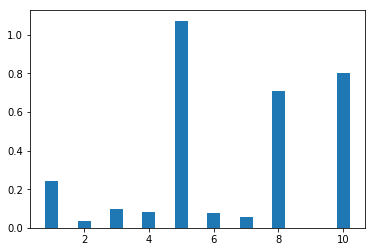

In [29]:
k=data.columns.values.tolist()
print(k)
k=k[1:]
p=[]
for i,name in enumerate(k):
    p.append(feature_woe_iv(data[name],y)[1])
    
print(p)
fig=plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
x = np.arange(len(k))+1
ax1.bar(x, p, width=0.4)#生成柱状图
plt.show()

In [26]:
#替换成woe
def replace_woe(series,cut,woe):
    list=[]
    i=0
    while i<len(series):
        value=series[i]
        j=len(cut)-2
        m=len(cut)-2
        while j>=0:
            if value>=cut[j]:
                j=-1
            else:
                j -=1
                m -= 1
        list.append(woe[m])
        i += 1
    return list


    
data['age'] = Series(replace_woe(data['age'],optimal_binning_boundary(x.age,y),feature_woe_iv(x.age,y)[0]))
data['NumberOfDependents'] = Series(replace_woe(data['NumberOfDependents'], optimal_binning_boundary(x.NumberOfDependents,y), feature_woe_iv(x.NumberOfDependents,y)[0]))
data['MonthlyIncome'] = Series(replace_woe(data['MonthlyIncome'], optimal_binning_boundary(x.MonthlyIncome,y), feature_woe_iv(x.MonthlyIncome,y)[0]))
data['DebtRatio'] = Series(replace_woe(data['DebtRatio'], optimal_binning_boundary(x.DebtRatio,y), feature_woe_iv(x.DebtRatio,y)[0]))
data['RevolvingUtilizationOfUnsecuredLines'] = Series(replace_woe(data['RevolvingUtilizationOfUnsecuredLines'], optimal_binning_boundary(x.RevolvingUtilizationOfUnsecuredLines,y), feature_woe_iv(x.RevolvingUtilizationOfUnsecuredLines,y)[0]))
data['NumberOfOpenCreditLinesAndLoans'] = Series(replace_woe(data['NumberOfOpenCreditLinesAndLoans'], optimal_binning_boundary(x.NumberOfOpenCreditLinesAndLoans,y), feature_woe_iv(x.NumberOfOpenCreditLinesAndLoans,y)[0]))
data['NumberRealEstateLoansOrLines'] = Series(replace_woe(data['NumberRealEstateLoansOrLines'], optimal_binning_boundary(x.NumberRealEstateLoansOrLines,y), feature_woe_iv(x.NumberRealEstateLoansOrLines,y)[0]))
data['NumberOfTime30-59DaysPastDueNotWorse'] = Series(replace_woe(data['NumberOfTime30-59DaysPastDueNotWorse'], optimal_binning_boundary(x['NumberOfTime30-59DaysPastDueNotWorse'],y), feature_woe_iv(x['NumberOfTime30-59DaysPastDueNotWorse'],y)[0]))
data['NumberOfTime60-89DaysPastDueNotWorse'] = Series(replace_woe(data['NumberOfTime60-89DaysPastDueNotWorse'], optimal_binning_boundary(x['NumberOfTime60-89DaysPastDueNotWorse'],y), feature_woe_iv(x['NumberOfTime60-89DaysPastDueNotWorse'],y)[0]))
data['NumberOfTimes90DaysLate'] = Series(replace_woe(data['NumberOfTimes90DaysLate'], optimal_binning_boundary(x.NumberOfTimes90DaysLate,y), feature_woe_iv(x.NumberOfTimes90DaysLate,y)[0]))


data.to_csv('WoeDatanew.csv', index=False)


In [32]:
datawoe = pd.read_csv('WoeDatanew.csv')

Y = datawoe['SeriousDlqin2yrs']
X = datawoe.ix[:, 1:]
Xnew=X.drop(['age','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTime60-89DaysPastDueNotWorse'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(Xnew, Y, test_size=0.3, random_state=0)

[[76731 18218]
 [ 2094  4697]]
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     94949
           1       0.20      0.69      0.32      6791

   micro avg       0.80      0.80      0.80    101740
   macro avg       0.59      0.75      0.60    101740
weighted avg       0.92      0.80      0.85    101740

[[32806  7884]
 [  880  2034]]
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     40690
           1       0.21      0.70      0.32      2914

   micro avg       0.80      0.80      0.80     43604
   macro avg       0.59      0.75      0.60     43604
weighted avg       0.92      0.80      0.84     43604

0.8278858530432402


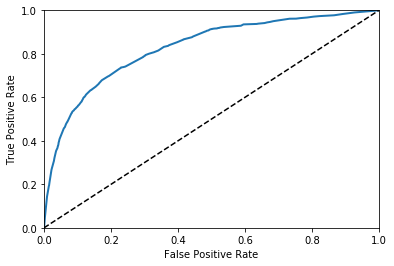

In [36]:
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

clf_lr_best=LogisticRegression(C=10,class_weight='balanced')
clf_lr_best.fit(x_train, y_train)

y_train_pred_lr= clf_lr_best.predict(x_train)
C1=confusion_matrix(y_train,y_train_pred_lr)
print(C1)
print(metrics.classification_report(y_train,y_train_pred_lr))

y_test_pred_lr = clf_lr_best.predict(x_test)
C3=confusion_matrix(y_test,y_test_pred_lr)
print(C3)
print(metrics.classification_report(y_test,y_test_pred_lr))

y_scores=clf_lr_best.decision_function(x_test)
fpr,tpr,threshholds=roc_curve(y_test,y_scores)
print(roc_auc_score(y_test,y_scores))
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)
plt.show()

## 评分卡建立

In [42]:
X1=sm.add_constant(x_train)
logit=sm.Logit(y_train,X1)
result=logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.192468
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               101740
Model:                          Logit   Df Residuals:                   101733
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                  0.2149
Time:                        10:42:28   Log-Likelihood:                -19582.
converged:                       True   LL-Null:                       -24941.
                                        LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.8003      0.0

In [43]:
coe=[-0.5680,0.2568,-0.5312,-0.6955,-0.6608,-0.7107]

[[-0.70287569  0.23863091 -0.54739352 -0.79544024 -0.75155945 -0.78085329]]


In [ ]:
#评分模型 score=a-b*log(odd)
#假设odd=1时，评分为600，odd=2时，评分为550，则得a=600 b=166
#可根据b*woe[i][j]*coe[i]判断不同变量的评分卡得分